# Tutorial: modelagem e documentação de sistemas distribuídos

Por: Marcelo Akira Inuzuka, em 2018-11-18

Sistemas distribuídos trocam mensagens entre componentes e os artefatos UML mais relevantes para documentação são:
* Os diagramas de sequência: modelam o comportamento do sistema, suas interações através do protocolo de comunicação.
* Os diagramas de componentes: modelam a estrutura do sistema, seus componentes que o compõe.

Para criar um diagrama de sequência em um notebook Jupyter, pode-se utilizar a biblioteca iplantuml. Neste tutorial, não irei demonstrar como instalar, procure o tutorial "Instalação do IPlantUML", disponível em [0].

## Sobre diagramas de sequência [1]

> Diagrama de Sequência é uma das ferramentas UML usadas para representar interações entre objetos de um cenário, realizadas através de operações ou métodos (procedimentos ou funções).
> O diagrama de sequência dá ênfase a ordenação temporal em que as mensagens são trocadas entre os objetos de um sistema. Entende-se por mensagens os serviços solicitados de um objecto a outro, e as respostas desenvolvidas para as solicitações. 

## Partes de um diagrama de sequência [1]

> **Mensagens:** A notação para uma mensagem em um diagrama de sequência é uma flecha (geralmente desenhada na horizontal) ligando uma linha de vida a outra. O objeto do qual parte a seta é aquele que está enviando a mensagem (objeto remetente). O objeto para o qual a seta aponta é aquele que está recebendo a mensagem (objeto receptor). O formato da ponta da seta indica o tipo de mensagem sendo enviada (síncrona ou assíncrona). O rótulo da mensagem é posicionado acima dessa seta. 

> **Atores:** São entidades externas que interagem com o sistema e que solicitam serviços. Normalmente, o ator primário é o responsável por enviar a mensagem inicial que inicia a interação entre os objetos.

> **Objetos:** Representam as instâncias das classes representadas no processo.

> **Gate:** Indica um ponto em que a mensagem pode ser transmitida para dentro ou para fora.

> **Fragmento:** Fragmentos de interação como: Alt (Alternativa), Opt (Opcional), Break (Parar), Loop (Repetição) e outras.

> **Linha de vida:** As linhas de vida compõem a dimensão vertical. Uma linha de vida é composta de duas partes, a cabeça e a cauda. A cabeça é representada por um retângulo com dois compartimentos, no compartimento superior a identificação do objeto é exibida e no compartimento inferior (cuja utilização é opcional), aparecem valores para os atributos definidos na classe do objeto. A cauda corresponde a uma linha vertical tracejada.

## Exemplo de criação de diagrama de sequência com IPlantUML [1]

![Exemplo Diagrama de Sequencia](Exemplo_seq.jpg)
Fonte: CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=1431838

Para criar o diagrama de sequência acima no IPlantUML [3]:

In [4]:
import iplantuml

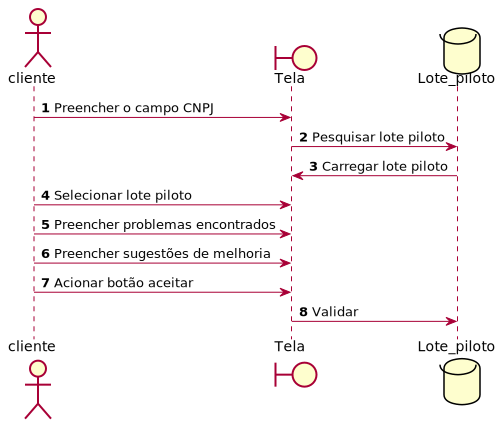

In [21]:
%%plantuml

@startuml
autonumber
actor cliente
boundary Tela
database Lote_piloto
cliente -> Tela : Preencher o campo CNPJ
Tela -> Lote_piloto : Pesquisar lote piloto
Lote_piloto -> Tela : Carregar lote piloto
cliente -> Tela : Selecionar lote piloto
cliente -> Tela : Preencher problemas encontrados
cliente -> Tela : Preencher sugestões de melhoria
cliente -> Tela : Acionar botão aceitar
Tela -> Lote_piloto : Validar

@enduml

## Criando diagramas de componentes

Diagramas de componentes descrevem como componentes são conectados entre si para formar um sistema maior. [8]

Quando se projeta um Sistema Distribuído (SD) é necesssário pensar em suas partes, como se comunicarão. Inicialmente pode ser bem abstrato e genérico, mas com o passar do tempo e da maturidade do projeto, pode-se tornar mais detalhado e específico. Por questões de agilidade, é comum equipes de desenvolvimento rascunharem um DS em uma folha de papel em um quadro branco. Este é um exemplo de rascunho:

![Rascunho Diagrama de Componentes](rascunho-diagrama-comp.png)

O rascunho acima faz parte de um projeto de um sistema de bate-papo multi-protocolo, que utiliza um middleware que utiliza fila de mensagem (MQ Server). As partes em tracejado não fazem parte do projeto principal, são consideradas como bônus, que potencialmente podem ser desenvolvidas como suporte a outros protocolos (Telegram) ou plataformas (Android). Um protótipo do esquema acima foi criado em [4], utilizando as seguintes tecnologias:
* MQ Server: RabbitMQ, que implementa o protocolo AMQP
* Linguagem de programação: NodeJS
* Biblioteca cliente IRC [5]: node-irc
* Servidor IRC: qualquer, em testes, foi utilizado o Hybrid IRC [6]

O rascunho pode ser desenhado por meio de um diagrama de componentes do IPlantUML:

In [23]:
import iplantuml

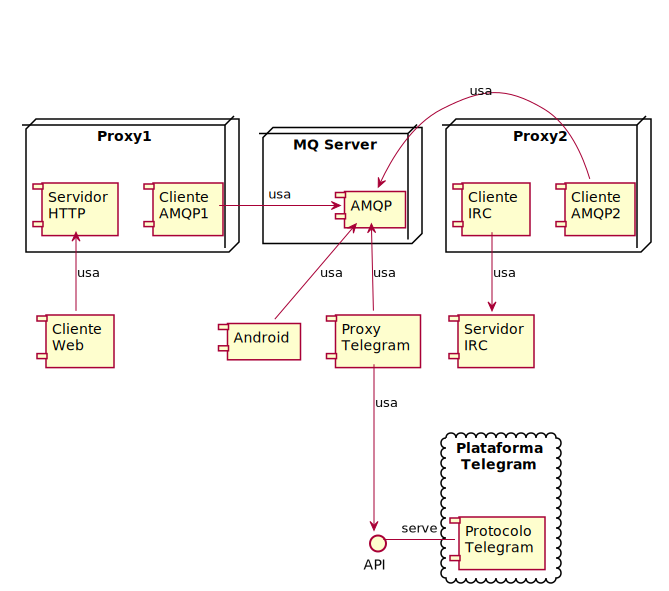

In [152]:
%%plantuml

@startuml
[Cliente\nWeb]
node "Proxy1" {
    [Servidor\nHTTP]
    [Cliente\nAMQP1]
}
[Cliente\nWeb] -up-> [Servidor\nHTTP] : usa
node "MQ Server" {
    [AMQP]
}
[Cliente\nAMQP1] -right-> AMQP : usa
[Android] -up-> AMQP: usa
[Proxy\nTelegram] -up-> AMQP: usa
[Proxy\nTelegram] -down-> API: usa
cloud "Plataforma\nTelegram" {
    [Protocolo\nTelegram] -right- API : serve
}
node "Proxy2" {
    [Cliente\nIRC]    
    [Cliente\nAMQP2]        
}
[Cliente\nAMQP2] -left-> [AMQP] : usa
[Cliente\nIRC] -down-> [Servidor\nIRC] : usa
@enduml

Note no diagrama acima, que alguns componentes podem ser detalhados, conforme a implementação vai se avançando:
* MQ Server: filas utilizadas;
* Servidor(es) IRC: canal(is) ou múltiplos servidores;
* Cliente(s) Web: múltiplos clientes, com detalhamento de ID;
* Proxy1: uso de cache, detalhamento de fila específica por cliente;
* Proxy2: instanciação de um cliente IRC por cliente, múltiplos canais, etc;

## Criando diagramas de sequência a partir do código

Em ciclos de modelagem/implementação comuns em uma metodologia ágil, é comum que a implementação se adiante a um modelo e para fins de documentação, é realizado um artefato que documenta o código produzido. Desta forma, pode-se produzir diagramas de sequência a partir de código produzido. Por exemplo, considerando-se o protótipo do projeto acima [4], podemos desenhar um diagrama de sequência de um caso de "registro de conexão".

## Exemplo de diagrama de sequência de um caso de uso:

* Caso de uso: registro de conexão de um usuário a um canal de um servidor específico
* Pré-condições:
 * não há cookies armazenados no servidor e portanto aparece a tela de login (login.html) para o usuário
 * o proxy1 (app.js) e proxy2 (irc-proxy.js) estão funcionando satisfatoriamente
 * os servidores MQServer e ServidorIRC estão funcionando satisfatoriamente
 * os dados preenchidos estão corretos
* Referências de mensagens do diagrama e seu respectivo código-fonte:
 * Mensagens 1 e 2: https://gitlab.com/marceloakira/p3/blob/master/login.html#L11
 * Mensagem 3: https://gitlab.com/marceloakira/p3/blob/master/app.js#L58
 * Mensagem 4: https://gitlab.com/marceloakira/p3/blob/master/app.js#L59
 * Mensagem 5: https://gitlab.com/marceloakira/p3/blob/master/app.js#L63
 * Mensagem 6: https://gitlab.com/marceloakira/p3/blob/master/app.js#L79
 * Mensagem 7: https://gitlab.com/marceloakira/p3/blob/master/app.js#L92
 * Mensagem 8: https://gitlab.com/marceloakira/p3/blob/master/irc-proxy.js#L22
 * Mensagem 9 e 10: https://gitlab.com/marceloakira/p3/blob/master/irc-proxy.js#L29
* Observações:
 * Como se trata de um protótipo, não há funcionalidade para tratar se o registro de conexão foi bem sucedido ou não. Assim, caso o usuário forneça algum dado que gere uma exceção usual, como um nickname registrado com senha, ele não será notificado de como resolver a exceção.
 * Além deste caso de uso, há outros que podem ter diagramas de sequência interessantes já para o protótipo inicial:
  * inicialização do proxy1 (app.js): conexão com servidor AMQP, criação e assinatura de fila;
  * inicialização do proxy2 (irc-proxy.js): conexão com servidor AMQP, criação e assinatura de fila;
  * envio de mensagem de usuário
  * recebimento de mensagem de usuário

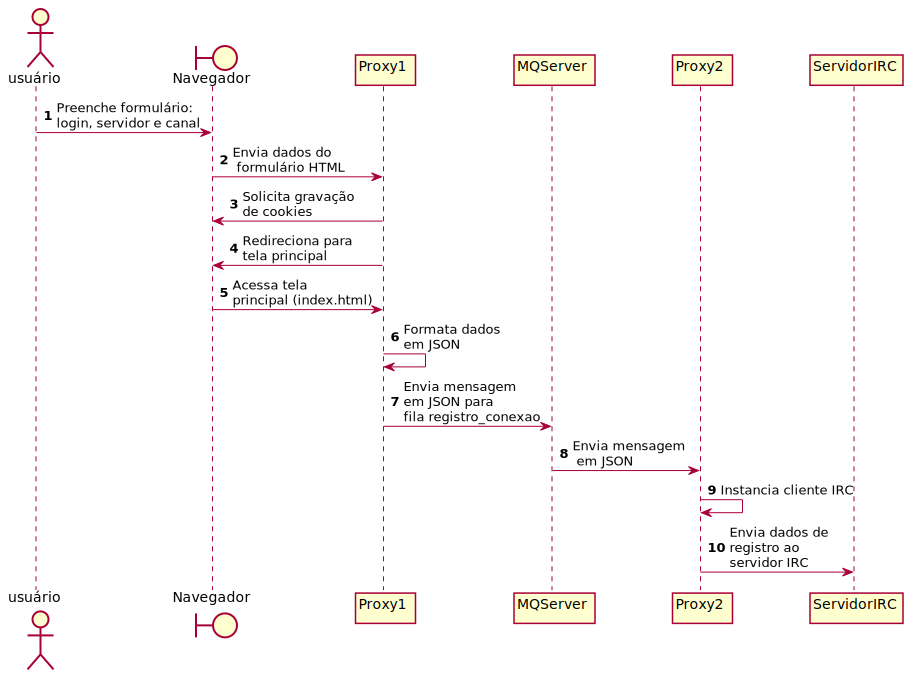

In [182]:
%%plantuml

@startuml
autonumber
actor usuário
boundary Navegador
usuário -> Navegador : Preenche formulário: \nlogin, servidor e canal
Navegador -> Proxy1 : Envia dados do\n formulário HTML
Proxy1 -> Navegador : Solicita gravação\nde cookies
Proxy1 -> Navegador : Redireciona para\ntela principal
Navegador -> Proxy1 : Acessa tela\nprincipal (index.html)
Proxy1 -> Proxy1: Formata dados\nem JSON
Proxy1 -> MQServer : Envia mensagem\nem JSON para\nfila registro_conexao
MQServer -> Proxy2: Envia mensagem\n em JSON
Proxy2 -> Proxy2: Instancia cliente IRC
Proxy2 -> ServidorIRC : Envia dados de\nregistro ao \nservidor IRC
@enduml

## Referências:
* [0] https://gitlab.com/marceloakira/tutorial/tree/master/instalacao-do-iplantuml
* [1] https://pt.wikipedia.org/wiki/Diagrama_de_sequ%C3%AAncia
* [3] http://plantuml.com/sequence-diagram
* [4] https://gitlab.com/marceloakira/p3
* [5] https://github.com/martynsmith/node-irc
* [6] http://www.ircd-hybrid.org/
* [7] http://plantuml.com/component-diagram
* [8] https://en.wikipedia.org/wiki/Component_diagram
* [9] https://gitlab.com/marceloakira/p3/blob/master/app.js